In [1]:
from ppget.source import ModelSource
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

start_date = "2007-07-01"
end_date = "2009-06-12"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: H, Name: Global_active_power, dtype: float64)

In [2]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.493733
2007-07-01 01:00:00    0.990900
2007-07-01 02:00:00    0.789900
2007-07-01 03:00:00    0.287467
2007-07-01 04:00:00    0.515533
Freq: H, Name: Global_active_power, dtype: float64

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
LAG = 1
WINDOW = 24

kw_hour = pd.DataFrame(zip(list(series.index), list(series.values),list(series.index.hour)))
kw_hour.columns = ["timestamp", "demand", "hour"]

standard_scaler = preprocessing.StandardScaler()
scaled_data = standard_scaler.fit_transform(kw_hour[["demand", "hour"]])
scaled_kw_hour = kw_hour.copy()
scaled_kw_hour["demand"] = scaled_data[:,0]
scaled_kw_hour["hour"] = scaled_data[:,1]
scaled_kw_hour.head(3)

,timestamp,demand,hour
0,2007-07-01 00:00:00,1.520326,-1.661325
1,2007-07-01 01:00:00,-0.116359,-1.516862
2,2007-07-01 02:00:00,-0.335261,-1.372399


In [4]:
training_size = int(len(scaled_kw_hour) * 0.9)
training, testing = scaled_kw_hour[0:training_size], scaled_kw_hour[training_size:len(kw_hour)]
print(f"Size of the dataset: {len(scaled_kw_hour)}")
print(f"Training examples: {len(training)}")
print(f"Testing examples: {len(testing)}")

Size of the dataset: 17088
Training examples: 15379
Testing examples: 1709


In [5]:
X_train = training[["demand", "hour"]].to_numpy()
y_train = scaled_kw_hour[LAG:testing.index[0]]["demand"].to_numpy()
X_test = testing[0:-LAG][["demand", "hour"]].to_numpy()
y_test = scaled_kw_hour[testing.index[0] + LAG:]["demand"].to_numpy()

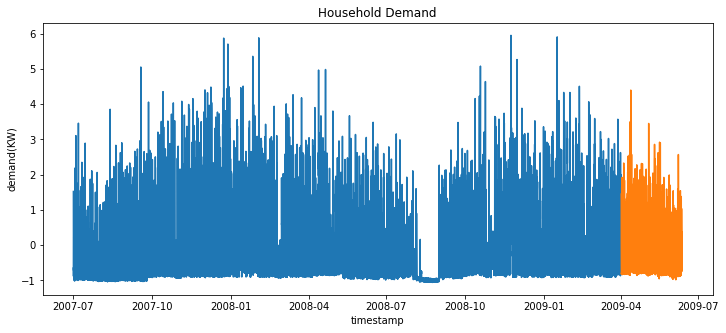

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training['timestamp'], X_train[:,0])
ax.plot(testing['timestamp'][0:-1], X_test[:,0])
ax.set_title('Household Demand')
plt.xlabel('timestamp')
plt.ylabel('demand(KW)')
plt.show()

In [7]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asarray(data_sequences)

X_train = create_sequence(X_train, WINDOW)
X_test  = create_sequence(X_test, WINDOW)
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]
y_train[0]

-0.9194363937221947

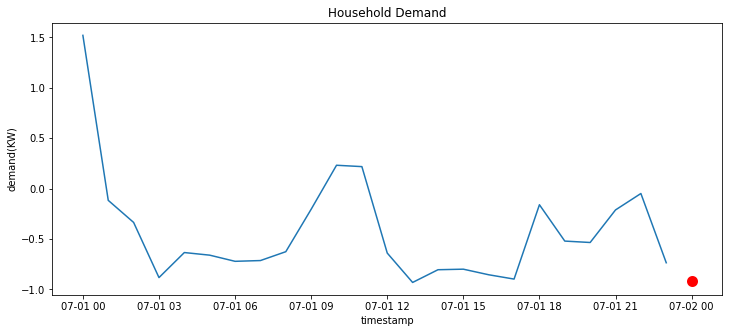

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training[0:WINDOW]['timestamp'], X_train[0,:,0])
ax.scatter(training[WINDOW:WINDOW + 1]['timestamp'], y_train[0], color='red', linewidth=5.0)
ax.set_title('Household Demand')
plt.xlabel('timestamp')
plt.ylabel('demand(KW)')
plt.show()

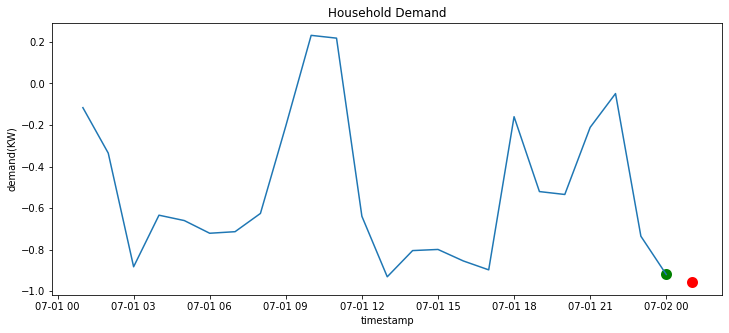

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training[1:WINDOW + 1]['timestamp'], X_train[1,:,0])
ax.scatter(training[WINDOW:WINDOW + 1]['timestamp'], y_train[0], color='green', linewidth=5.0)
ax.scatter(training[WINDOW + 1:WINDOW + 2]['timestamp'], y_train[1], color='red', linewidth=5.0)
ax.set_title('Household Demand')
plt.xlabel('timestamp')
plt.ylabel('demand(KW)')
plt.show()

In [13]:
model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
model.add(Dropout(0.5))
model.add(LSTM(16,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            17152     
                                                                 
 dropout_2 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,353
Trainable params: 22,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
# Training the model
history = model.fit(X_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
120/120 [==============================] - 4s 37ms/step - loss: 0.4650
Epoch 2/100
120/120 [==============================] - 2s 21ms/step - loss: 0.4651
Epoch 3/100
120/120 [==============================] - 2s 20ms/step - loss: 0.4617
Epoch 4/100
120/120 [==============================] - 2s 21ms/step - loss: 0.4615
Epoch 5/100
120/120 [==============================] - 3s 21ms/step - loss: 0.4600
Epoch 6/100
120/120 [==============================] - 3s 22ms/step - loss: 0.4607
Epoch 7/100
120/120 [==============================] - 4s 36ms/step - loss: 0.4541
Epoch 8/100
120/120 [==============================] - 5s 39ms/step - loss: 0.4616
Epoch 9/100
120/120 [==============================] - 3s 28ms/step - loss: 0.4574
Epoch 10/100
120/120 [==============================] - 5s 42ms/step - loss: 0.4503
Epoch 11/100
120/120 [==============================] - 4s 37ms/step - loss: 0.4522
Epoch 12/100
120/120 [==============================] - 4s 31ms/step - loss: 0.4483
E

In [17]:
predictions = model.predict(X_test)
len(predictions)

53/53 [==============================] - 2s 8ms/step


1684

In [18]:
def evaluate_predictions(predictions, y_test, outliers):
    ratio = []
    differences = []
    for pred in range(len(y_test)):
        ratio.append((y_test[pred]/predictions[pred])-1)
        differences.append(abs(y_test[pred]- predictions[pred]))


    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)

    return ratio, differences, outliers

ratio, differences, outliers = evaluate_predictions(predictions, y_test, 0.01)
for index in outliers.index:
    outliers[index] = predictions[index]
outliers

167    -0.383165
744     0.588585
1577   -0.002637
908     0.297357
505    -0.409151
911     0.220478
1070    0.378514
215     1.028401
409    -0.127115
542    -0.078143
1343   -0.676700
745    -0.183142
242     2.768375
575     1.858810
66      1.582938
1321   -0.269209
dtype: float64

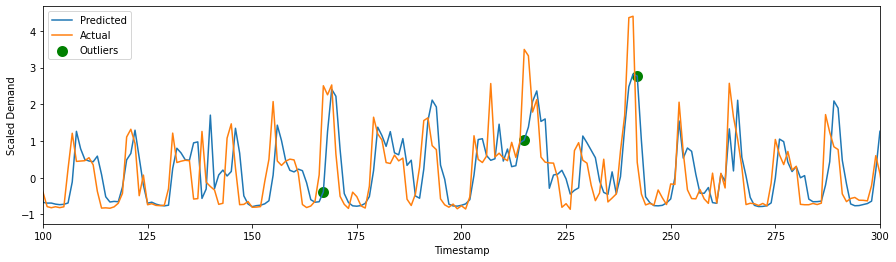

In [21]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

plt.xlim([100, 300])
axs.plot(predictions, label='Predicted')
axs.plot(y_test, label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Scaled Demand')
plt.legend(loc='upper left')
plt.show()